In [17]:
%load_ext autoreload

%autoreload 2

import os
from glob import glob
import subprocess
import shutil
import traceback
import random
import pickle
from os.path import join

import joblib
from concurrent.futures import ProcessPoolExecutor

from backports import tempfile

import matplotlib
matplotlib.rcParams['savefig.dpi'] = 144
matplotlib.rcParams["image.composite_image"]=False
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from numpy.fft import rfft, irfft, fft, ifft

import psrchive
import residuals

import pipe
from pipe import rotate_phase, convert_template, align_profile, align_scale_profile

import astropy.units as u
import astropy.coordinates

plt.viridis()

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
#obs = "data/obs/56005.83_AO_1400"
obs = "data/obs/57400.02_AO_1400"
processing_name = "wideband"

In [29]:
scrunches = sorted(glob(join(obs,processing_name,"scrunch_*.ar")))
scrunches

['data/obs/57400.02_AO_1400/wideband/scrunch_0000.ar']

In [30]:
F = psrchive.Archive_load(scrunches[0])


In [31]:
for i in range(len(F)):
    I = F.get_Integration(i)
    print(I.get_start_time().in_days(), I.get_end_time().in_days(), 
          I.get_telescope_zenith(), I.get_telescope_azimuth())

(57400.01240535052, 57400.01252397899, 4.89955997467041, -78.40200805664062)
(57400.01252387179, 57400.01264250026, 4.85673999786377, -78.28399658203125)
(57400.012642361435, 57400.01276098991, 4.8180198669433585, -78.17599487304688)
(57400.0127608827, 57400.01287951118, 4.779099941253663, -78.06399536132812)
(57400.01287940398, 57400.01299803245, 4.740379810333251, -77.9530029296875)
(57400.01299789362, 57400.01311652209, 4.701560020446778, -77.8380126953125)
(57400.013116414884, 57400.013235043356, 4.65914011001587, -77.71099853515624)
(57400.01323493615, 57400.013353564624, 4.62401008605957, -77.60598754882812)
(57400.01335342579, 57400.01347205426, 4.5776000022888175, -77.46099853515625)
(57400.01347194706, 57400.01359057553, 4.538980007171631, -77.34100341796875)
(57400.01359046833, 57400.0137090968, 4.496389865875242, -77.20401000976562)
(57400.01370895796, 57400.01382758643, 4.46150016784668, -77.09100341796875)
(57400.013827479226, 57400.0139461077, 4.419229984283448, -76.95001

In [9]:
I.get_epoch().in_days()

57400.03095239069

In [10]:
F.get_source()

'J0337+1715'

In [11]:
C = F.get_coordinates()

In [12]:
C.getDegrees()

'( 54.4325, 17.2542)'

In [13]:
a = C.angle1

In [14]:
a.getDegrees()

54.43249999999999

In [15]:
radeg, decdeg = F.get_coordinates().angle1.getDegrees(), F.get_coordinates().angle2.getDegrees() 
radeg, decdeg

(54.43249999999999, 17.254166666666666)

In [18]:
# from obsys.dat
arecibo_location = astropy.coordinates.EarthLocation(x=2390490.0*u.m,y=-5564764.0*u.m,z=1994727.0*u.m)

In [50]:
sts = []
mts = []
ets = []
zas_file = []
zas_astropy = []
azs_file = []
azs_astropy = []
separations = []

for i in range(len(F)):
    I = F.get_Integration(i)
    mt = (I.get_start_time().in_days()+I.get_end_time().in_days())/2
    st = I.get_start_time().in_days()
    et = I.get_end_time().in_days()
    mts.append(mt)
    sts.append(st)
    ets.append(et)
    
    t = astropy.time.Time(st, format='mjd')
    radeg, decdeg = (F.get_coordinates().angle1.getDegrees(), 
                     F.get_coordinates().angle2.getDegrees()) 
    srcpos = astropy.coordinates.SkyCoord(ra=radeg*u.degree, dec=decdeg*u.degree, frame='icrs')
    altaz = srcpos.transform_to(astropy.coordinates.AltAz(
            obstime=t, location=arecibo_location))
    zas_file.append(I.get_telescope_zenith())
    azs_astropy.append(altaz.az.value)
    azs_file.append(I.get_telescope_azimuth()+180)
    zas_astropy.append(90-altaz.alt.value)
    altaz_point = astropy.coordinates.AltAz(
            obstime=t, location=arecibo_location,
            alt=(90-I.get_telescope_zenith())*u.degree,
            az=(180+I.get_telescope_azimuth())*u.degree)
    separations.append(altaz.separation(altaz_point).value)

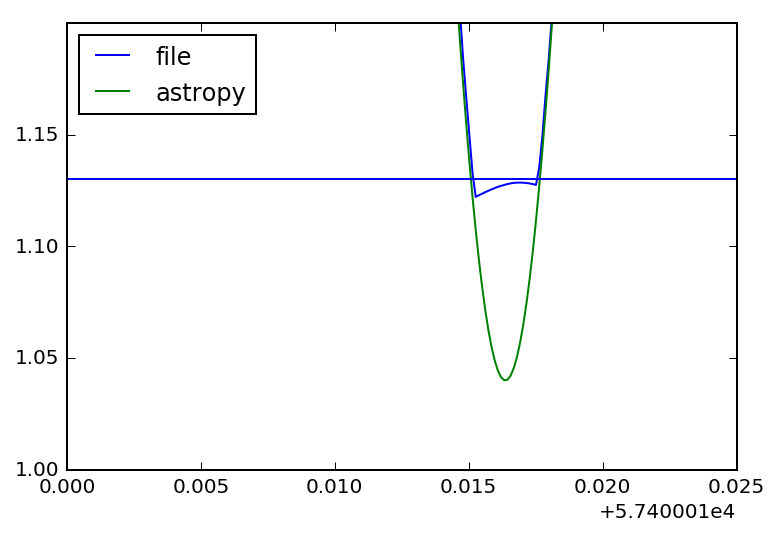

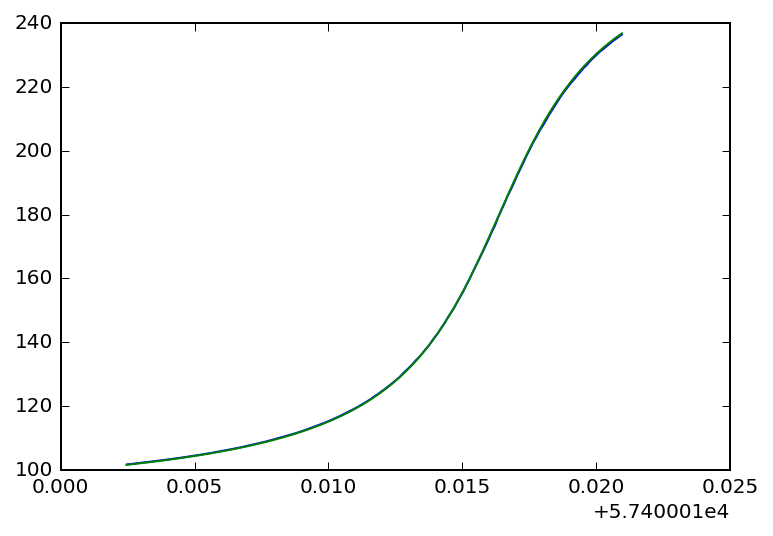

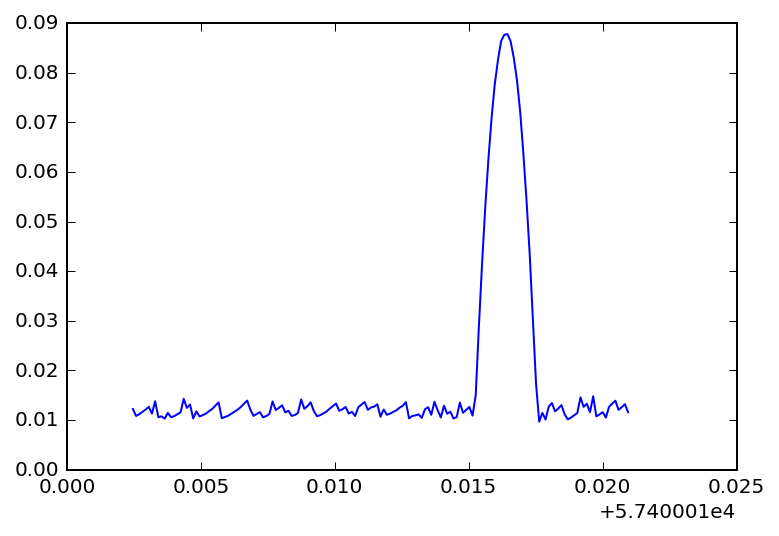

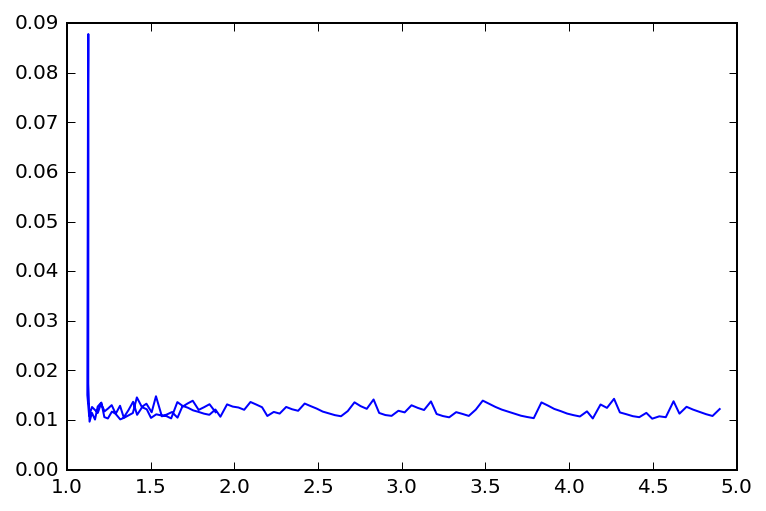

In [51]:
plt.plot(mts,zas_file, label="file")
plt.plot(mts,zas_astropy, label="astropy")
plt.axhline(1.13)
plt.ylim(1.0,1.2)
plt.legend(loc="best")
plt.figure()
plt.plot(mts,azs_file, label="file")
plt.plot(mts,azs_astropy, label="astropy")
plt.figure()
plt.plot(mts,separations)
plt.figure()
plt.plot(zas_file,separations)

In [32]:
o = (1*u.degree)

In [34]:
o.value

1.0

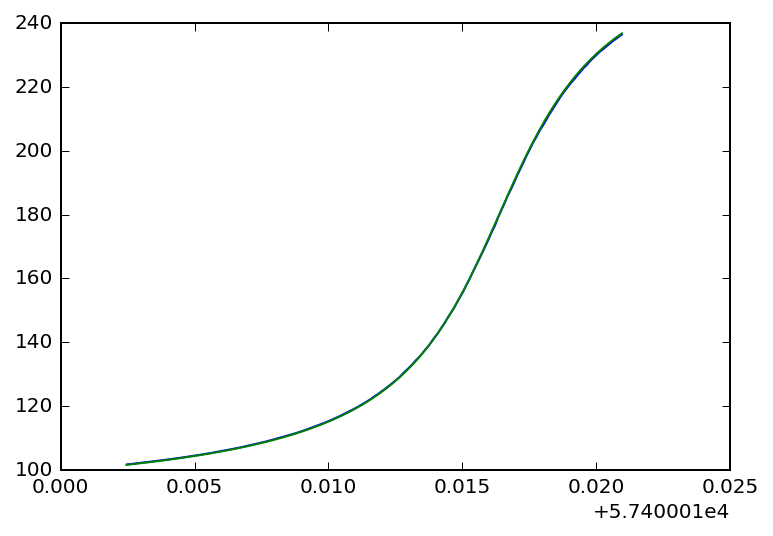

In [43]:
plt.plot(mts,np.array(azs_file)+180, label="file")
plt.plot(mts,azs_astropy, label="astropy")
